In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# generate data
X, y = datasets.make_classification(n_samples=10000, n_features=50, n_redundant=10, n_informative=10,
                           random_state=1, n_clusters_per_class=2,n_classes=3, class_sep=2)
                           
# divide data in Train - Validation - Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

In [3]:
# Standardize Data
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

In [4]:
X_tr_std.shape, X_valid_std.shape, X_test_std.shape

((5600, 50), (1400, 50), (3000, 50))

In [5]:
X_tr_std[0,:]

array([ 0.59334314,  0.52721715,  1.53370642, -1.21499106,  0.85494328,
       -1.01174125, -0.13709395,  0.27116551, -1.35840995,  0.38316285,
       -1.80562261,  0.77231744, -0.10136654, -1.72445007,  0.80084157,
        1.07127131, -1.02117321,  1.88689303,  0.47973734,  1.15321088,
       -1.72360196,  0.04005203,  0.1370787 , -1.17758567,  0.41575645,
        0.99833954, -0.9873226 ,  1.3149827 , -0.41228458,  0.54168616,
        0.57370084,  0.15308426,  0.17779104,  1.24262095, -1.91463002,
       -0.10850135,  1.12389814,  1.10117653, -1.17006424, -0.15831138,
       -0.84786721,  0.14786847,  0.69898008, -0.61954192, -1.19219641,
        2.25379492,  0.15576535,  0.39963977,  0.41317107, -0.16946119])

In [6]:
X_tr_std=torch.from_numpy(X_tr_std).float()
X_valid_std=torch.from_numpy(X_valid_std).float()

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(50,2))
        self.decoder = nn.Sequential(nn.Linear(2,50))
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay = 1e-5)

tr_dataloader = DataLoader(X_tr_std, batch_size=100, shuffle=True)
vl_dataloader = DataLoader(X_valid_std, batch_size=100, shuffle=True)
num_batches = len(tr_dataloader)
num_epochs = 100

for epoch in range(num_epochs):
    for i, data in enumerate(tr_dataloader):
        da = data
        output = model(da)
        loss = criterion(output, da)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%10 == 0:
            with torch.no_grad():
                val_loss = 0.0
                for j, val in enumerate(vl_dataloader):
                    va = val
                    output = model(va)
                    val_loss = criterion(output, va)
                    
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, loss / 100, val_loss / len(vl_dataloader)
            ))            
        
    #rint('epoch[{}/{}], loss:{:.4f}'.format(epoch+1, 100, loss.data))
   

epoch: 1/100 | step: 10/56 | trn loss: 0.0133 | val loss: 0.0905
epoch: 1/100 | step: 20/56 | trn loss: 0.0121 | val loss: 0.0870
epoch: 1/100 | step: 30/56 | trn loss: 0.0118 | val loss: 0.0859
epoch: 1/100 | step: 40/56 | trn loss: 0.0119 | val loss: 0.0849
epoch: 1/100 | step: 50/56 | trn loss: 0.0114 | val loss: 0.0851
epoch: 2/100 | step: 10/56 | trn loss: 0.0109 | val loss: 0.0812
epoch: 2/100 | step: 20/56 | trn loss: 0.0112 | val loss: 0.0772
epoch: 2/100 | step: 30/56 | trn loss: 0.0107 | val loss: 0.0764
epoch: 2/100 | step: 40/56 | trn loss: 0.0110 | val loss: 0.0801
epoch: 2/100 | step: 50/56 | trn loss: 0.0105 | val loss: 0.0769
epoch: 3/100 | step: 10/56 | trn loss: 0.0104 | val loss: 0.0725
epoch: 3/100 | step: 20/56 | trn loss: 0.0107 | val loss: 0.0720
epoch: 3/100 | step: 30/56 | trn loss: 0.0104 | val loss: 0.0754
epoch: 3/100 | step: 40/56 | trn loss: 0.0101 | val loss: 0.0750
epoch: 3/100 | step: 50/56 | trn loss: 0.0103 | val loss: 0.0732
epoch: 4/100 | step: 10/5

In [8]:
print(X_tr_std.shape)
codings = model.encoder(X_tr_std)
print(codings.shape)

torch.Size([5600, 50])
torch.Size([5600, 2])


In [9]:
codings.detach().numpy().shape, np.unique(y_tr, return_counts=True)

((5600, 2), (array([0, 1, 2]), array([1896, 1851, 1853])))

In [10]:
codings = codings.detach().numpy()

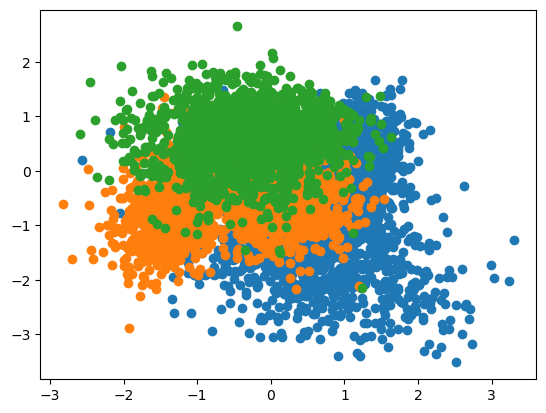

In [11]:
for class_value in range(3):
    # get row indexes for samples with this class
    row_ix = y_tr == class_value
    # create scatter of these samples
    plt.scatter(codings[row_ix, 0], codings[row_ix, 1])
plt.show()

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,svd_solver='auto')
scores = pca.fit_transform(X_tr_std) # u

In [13]:
scores.shape

(5600, 2)

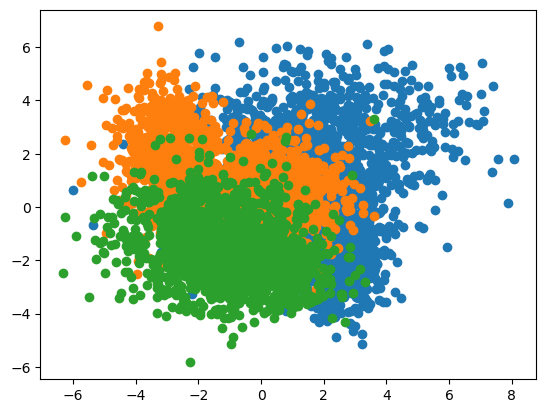

In [14]:
for class_value in range(3):
    # get row indexes for samples with this class
    row_ix = y_tr == class_value
    # create scatter of these samples
    plt.scatter(scores[row_ix, 0], scores[row_ix, 1])
plt.show()